## Process data by drive

In [1]:
import importlib
import main

Using TensorFlow backend.
D:\Apps\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [365]:
importlib.reload(main)

<module 'main' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\main.py'>

In [366]:
main.drive('../../data/', 'dump/', '2018-09-01')

Raw data shapes:
que (22726, 5) (23931, 5)
ans (45838, 5) (51123, 5)
pro (22658, 5) (28152, 5)
stu (29631, 3) (30971, 3)
tag_que (76553, 4)
tag_pro (76553, 4)
Train
Positive pairs number: 44474, negative: 44474
Questions:  (22726, 16)


Students features: 22597it [00:19, 1146.70it/s]


Students:  (34282, 15)


Professionals features: 44848it [00:09, 4925.90it/s]


Professionals:  (53512, 34)
Train data dump.

Test
Positive pairs number: 5249, negative: 49723
Questions:  (23931, 16)


Students features: 23801it [00:22, 1073.70it/s]


Students:  (36105, 15)


Professionals features: 50106it [00:10, 4962.67it/s]


Professionals:  (60173, 34)
Test data dump.



## Load processed data

In [9]:
import pickle
import pandas as pd
import evaluation

In [10]:
with open('proc_data/train_que_data.pkl', 'rb') as f:
    train_que_data = pickle.load(f)
with open('proc_data/train_stu_data.pkl', 'rb') as f:
    train_stu_data = pickle.load(f)
with open('proc_data/train_pro_data.pkl', 'rb') as f:
    train_pro_data = pickle.load(f)
with open('proc_data/train_pos_pairs.pkl', 'rb') as f:
    train_pos_pairs = pickle.load(f)
with open('proc_data/train_nonneg_pairs.pkl', 'rb') as f:
    train_nonneg_pairs = pickle.load(f)
with open('proc_data/train_pro_dates.pkl', 'rb') as f:
    train_pro_dates = pickle.load(f)

In [11]:
with open('proc_data/test_que_data.pkl', 'rb') as f:
    test_que_data = pickle.load(f)
with open('proc_data/test_stu_data.pkl', 'rb') as f:
    test_stu_data = pickle.load(f)
with open('proc_data/test_pro_data.pkl', 'rb') as f:
    test_pro_data = pickle.load(f)
with open('proc_data/test_pos_pairs.pkl', 'rb') as f:
    test_pos_pairs = pickle.load(f)
with open('proc_data/test_nonneg_pairs.pkl', 'rb') as f:
    test_nonneg_pairs = pickle.load(f)
with open('proc_data/test_pro_dates.pkl', 'rb') as f:
    test_pro_dates = pickle.load(f)

In [12]:
with open('dump/preprocessors.pkl', 'rb') as f:
    pp = pickle.load(f)
    que_proc = pp['questions_date_added_time']

## Create train and test batch generators

In [13]:
import generator

In [14]:
importlib.reload(generator)

<module 'generator' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\generator.py'>

In [15]:
train_bg = generator.BatchGenerator(
    train_que_data, train_stu_data, train_pro_data, 64,
    train_pos_pairs, train_nonneg_pairs, que_proc, train_pro_dates)
print('Batches:', len(train_bg))

Batches: 694


In [16]:
test_bg = generator.BatchGenerator(
    test_que_data, test_stu_data, test_pro_data, 64,
    test_pos_pairs, test_nonneg_pairs, que_proc, test_pro_dates)
print('Batches:', len(test_bg))

Batches: 82


---

## Compute que_date_mask and pro_date_mask

In [17]:
import numpy as np
import re

In [18]:
que_cols = list(train_stu_data.columns[2:]) + list(train_que_data.columns[2:]) + ['questions_current_time']
pro_cols = list(train_pro_data.columns[2:]) + ['professionals_current_time']
print(len(que_cols), len(pro_cols))
print(train_bg[0][0][0].shape[1], train_bg[0][0][1].shape[1])

28 33
28 33


In [19]:
que_content_mask = np.zeros(len(que_cols)-1, dtype=bool) # Change
for i, col in enumerate(que_cols[:-1]): # Change
    if re.search(r'emb', col):
        que_content_mask[i] = True
(que_content_mask == 1).sum()

10

In [20]:
pro_content_mask = np.zeros(len(pro_cols)-1, dtype=bool) # Change
for i, col in enumerate(pro_cols[:-1]): # Change
    if re.search(r'emb', col):
        pro_content_mask[i] = True
(pro_content_mask == 1).sum()

20

In [21]:
que_content_mask.size, pro_content_mask.size

(27, 32)

---

## Model training and testing

In [22]:
from keras.optimizers import Adam
import models

In [23]:
importlib.reload(models)

<module 'models' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\models.py'>

In [24]:
content_model = models.ContentModel(
    len(que_cols), que_content_mask,
    len(pro_cols), pro_content_mask,
    10, 5,
)

In [25]:
content_model.compile(Adam(lr=.01), loss='binary_crossentropy', metrics=['accuracy'])
content_model.fit_generator(train_bg, epochs=2)

content_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])
content_model.fit_generator(train_bg, epochs=2)

content_model.evaluate_generator(test_bg)

Epoch 1/2
694/694 [==============================] - ETA: 17:18 - loss: 1.6765 - acc: 0.50 - ETA: 3:35 - loss: 1.3514 - acc: 0.5078 - ETA: 2:18 - loss: 1.1961 - acc: 0.511 - ETA: 1:43 - loss: 1.1020 - acc: 0.507 - ETA: 1:23 - loss: 1.0331 - acc: 0.519 - ETA: 1:06 - loss: 0.9659 - acc: 0.526 - ETA: 55s - loss: 0.9212 - acc: 0.526 - ETA: 48s - loss: 0.8858 - acc: 0.54 - ETA: 42s - loss: 0.8617 - acc: 0.54 - ETA: 38s - loss: 0.8438 - acc: 0.54 - ETA: 35s - loss: 0.8268 - acc: 0.55 - ETA: 32s - loss: 0.8121 - acc: 0.55 - ETA: 30s - loss: 0.7988 - acc: 0.55 - ETA: 28s - loss: 0.7863 - acc: 0.56 - ETA: 26s - loss: 0.7747 - acc: 0.57 - ETA: 25s - loss: 0.7650 - acc: 0.57 - ETA: 24s - loss: 0.7549 - acc: 0.58 - ETA: 23s - loss: 0.7475 - acc: 0.58 - ETA: 22s - loss: 0.7414 - acc: 0.58 - ETA: 21s - loss: 0.7337 - acc: 0.59 - ETA: 20s - loss: 0.7280 - acc: 0.59 - ETA: 19s - loss: 0.7225 - acc: 0.59 - ETA: 19s - loss: 0.7190 - acc: 0.60 - ETA: 18s - loss: 0.7130 - acc: 0.60 - ETA: 18s - loss: 0.71

694/694 [==============================] - ETA: 4:40 - loss: 0.5912 - acc: 0.687 - ETA: 1:03 - loss: 0.5872 - acc: 0.695 - ETA: 39s - loss: 0.5821 - acc: 0.697 - ETA: 28s - loss: 0.5730 - acc: 0.70 - ETA: 23s - loss: 0.5705 - acc: 0.69 - ETA: 20s - loss: 0.5643 - acc: 0.70 - ETA: 18s - loss: 0.5618 - acc: 0.70 - ETA: 17s - loss: 0.5632 - acc: 0.70 - ETA: 16s - loss: 0.5622 - acc: 0.70 - ETA: 15s - loss: 0.5655 - acc: 0.70 - ETA: 14s - loss: 0.5635 - acc: 0.70 - ETA: 14s - loss: 0.5627 - acc: 0.70 - ETA: 13s - loss: 0.5622 - acc: 0.70 - ETA: 13s - loss: 0.5623 - acc: 0.70 - ETA: 12s - loss: 0.5616 - acc: 0.70 - ETA: 12s - loss: 0.5602 - acc: 0.71 - ETA: 12s - loss: 0.5602 - acc: 0.71 - ETA: 11s - loss: 0.5584 - acc: 0.71 - ETA: 11s - loss: 0.5567 - acc: 0.71 - ETA: 11s - loss: 0.5581 - acc: 0.71 - ETA: 11s - loss: 0.5577 - acc: 0.71 - ETA: 10s - loss: 0.5555 - acc: 0.71 - ETA: 10s - loss: 0.5556 - acc: 0.71 - ETA: 10s - loss: 0.5548 - acc: 0.71 - ETA: 10s - loss: 0.5556 - acc: 0.71 - ET

[0.5624418502173772, 0.7139862804878049]

In [26]:
content_model.save_weights('content_model.h5')

In [27]:
date_model = models.DateModel(
    len(que_cols), ~que_content_mask, [102, 42], [2, 2],
    len(pro_cols), ~pro_content_mask, [102, 102, 42], [2, 2, 2],
    10, 5,
)

In [28]:
date_model.compile(Adam(lr=.01), loss='binary_crossentropy', metrics=['accuracy'])
date_model.fit_generator(train_bg, epochs=3)

date_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])
date_model.fit_generator(train_bg, epochs=2)

date_model.evaluate_generator(test_bg)

Epoch 1/3
694/694 [==============================] - ETA: 8:28 - loss: 2.5592 - acc: 0.500 - ETA: 1:50 - loss: 2.1521 - acc: 0.501 - ETA: 1:05 - loss: 1.6805 - acc: 0.511 - ETA: 48s - loss: 1.3759 - acc: 0.548 - ETA: 41s - loss: 1.2418 - acc: 0.56 - ETA: 34s - loss: 1.1106 - acc: 0.59 - ETA: 31s - loss: 1.0469 - acc: 0.60 - ETA: 28s - loss: 0.9771 - acc: 0.62 - ETA: 25s - loss: 0.9220 - acc: 0.63 - ETA: 23s - loss: 0.8844 - acc: 0.64 - ETA: 22s - loss: 0.8461 - acc: 0.65 - ETA: 20s - loss: 0.8125 - acc: 0.67 - ETA: 19s - loss: 0.7915 - acc: 0.67 - ETA: 19s - loss: 0.7743 - acc: 0.67 - ETA: 18s - loss: 0.7546 - acc: 0.68 - ETA: 17s - loss: 0.7395 - acc: 0.68 - ETA: 17s - loss: 0.7273 - acc: 0.69 - ETA: 16s - loss: 0.7165 - acc: 0.69 - ETA: 16s - loss: 0.7057 - acc: 0.70 - ETA: 16s - loss: 0.6982 - acc: 0.70 - ETA: 15s - loss: 0.6877 - acc: 0.70 - ETA: 15s - loss: 0.6799 - acc: 0.70 - ETA: 15s - loss: 0.6692 - acc: 0.71 - ETA: 14s - loss: 0.6632 - acc: 0.71 - ETA: 14s - loss: 0.6566 - ac

694/694 [==============================] - ETA: 1:35 - loss: 0.2953 - acc: 0.875 - ETA: 1:22 - loss: 0.2872 - acc: 0.886 - ETA: 40s - loss: 0.3010 - acc: 0.889 - ETA: 26s - loss: 0.3059 - acc: 0.88 - ETA: 21s - loss: 0.2993 - acc: 0.89 - ETA: 19s - loss: 0.3004 - acc: 0.88 - ETA: 17s - loss: 0.3068 - acc: 0.88 - ETA: 15s - loss: 0.3129 - acc: 0.88 - ETA: 15s - loss: 0.3139 - acc: 0.87 - ETA: 14s - loss: 0.3157 - acc: 0.87 - ETA: 13s - loss: 0.3155 - acc: 0.87 - ETA: 12s - loss: 0.3145 - acc: 0.87 - ETA: 12s - loss: 0.3134 - acc: 0.87 - ETA: 12s - loss: 0.3126 - acc: 0.87 - ETA: 12s - loss: 0.3125 - acc: 0.87 - ETA: 11s - loss: 0.3140 - acc: 0.87 - ETA: 11s - loss: 0.3153 - acc: 0.87 - ETA: 11s - loss: 0.3142 - acc: 0.87 - ETA: 11s - loss: 0.3135 - acc: 0.87 - ETA: 10s - loss: 0.3133 - acc: 0.87 - ETA: 10s - loss: 0.3139 - acc: 0.87 - ETA: 10s - loss: 0.3140 - acc: 0.87 - ETA: 10s - loss: 0.3144 - acc: 0.87 - ETA: 10s - loss: 0.3144 - acc: 0.87 - ETA: 10s - loss: 0.3137 - acc: 0.87 - ET

694/694 [==============================] - ETA: 7s - loss: 0.3024 - acc: 0.867 - ETA: 28s - loss: 0.2964 - acc: 0.89 - ETA: 18s - loss: 0.2926 - acc: 0.89 - ETA: 14s - loss: 0.2945 - acc: 0.88 - ETA: 13s - loss: 0.2921 - acc: 0.88 - ETA: 12s - loss: 0.2888 - acc: 0.88 - ETA: 12s - loss: 0.2891 - acc: 0.88 - ETA: 12s - loss: 0.2854 - acc: 0.88 - ETA: 11s - loss: 0.2830 - acc: 0.89 - ETA: 11s - loss: 0.2824 - acc: 0.89 - ETA: 11s - loss: 0.2842 - acc: 0.89 - ETA: 10s - loss: 0.2845 - acc: 0.89 - ETA: 10s - loss: 0.2857 - acc: 0.89 - ETA: 10s - loss: 0.2868 - acc: 0.89 - ETA: 10s - loss: 0.2880 - acc: 0.89 - ETA: 10s - loss: 0.2877 - acc: 0.89 - ETA: 9s - loss: 0.2891 - acc: 0.8914 - ETA: 9s - loss: 0.2888 - acc: 0.891 - ETA: 9s - loss: 0.2879 - acc: 0.892 - ETA: 9s - loss: 0.2879 - acc: 0.892 - ETA: 9s - loss: 0.2898 - acc: 0.891 - ETA: 9s - loss: 0.2900 - acc: 0.891 - ETA: 9s - loss: 0.2896 - acc: 0.891 - ETA: 9s - loss: 0.2900 - acc: 0.890 - ETA: 8s - loss: 0.2903 - acc: 0.890 - ETA: 8

[0.25804468553240706, 0.9065358231707317]

In [29]:
date_model.save_weights('date_model.h5')

In [130]:
preds = []
true = []
for batch in train_bg:
    content_score = content_model.predict(batch[0])
    date_score = date_model.predict(batch[0])
    pred = np.hstack([content_score, date_score])
    
    preds.append(pred)
    true.append(batch[1])

In [177]:
pred = np.vstack(preds)
true = np.vstack(true).reshape((-1))
pred.shape, true.shape

((88832, 2), (88832,))

In [361]:
cont_pred = pred[:, 0] > 0.5
date_pred = pred[:, 1] > 0.5
(cont_pred == true).mean(), (date_pred == true).mean()

(0.7215192723342939, 0.8938783321325648)

---

## Evaluating feature importance

In [52]:
train_big_bg = generator.BatchGenerator(
    train_que_data, train_stu_data, train_pro_data, 512,
    train_pos_pairs, train_nonneg_pairs, que_proc, train_pro_dates)

test_big_bg = generator.BatchGenerator(
    test_que_data, test_stu_data, test_pro_data, 512,
    test_pos_pairs, test_nonneg_pairs, que_proc, test_pro_dates)

In [53]:
importlib.reload(evaluation)

<module 'evaluation' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\evaluation.py'>

In [55]:
qfn, pfn = np.array(que_cols[:-1]), np.array(pro_cols[:-1]) # Change

### Content model feature importance

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - ETA:  - 0s 128us/step


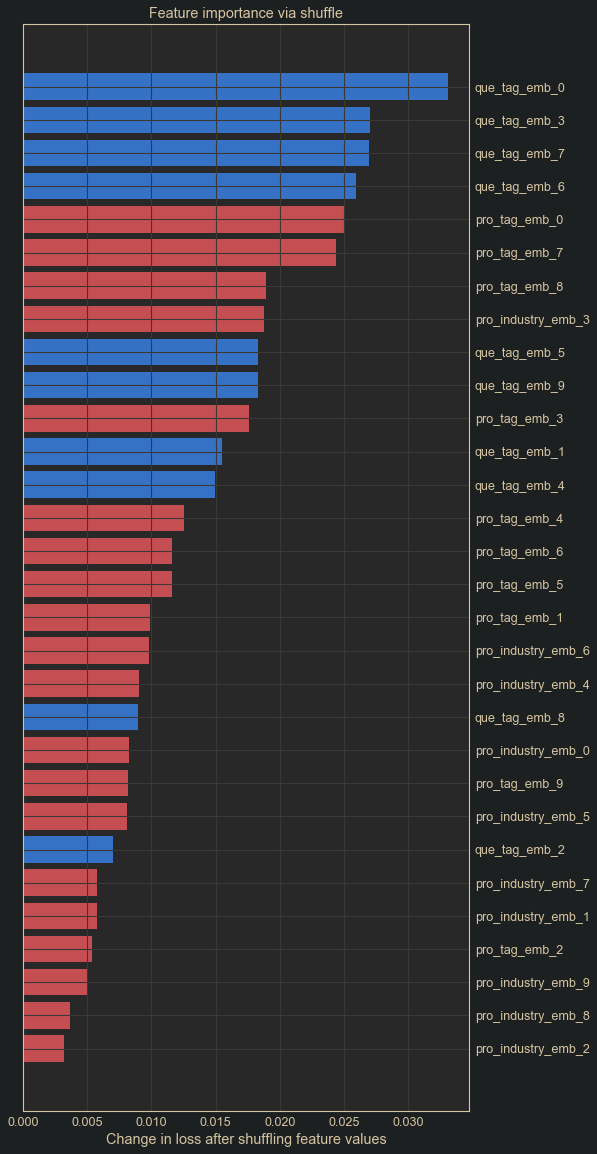

In [88]:
# calculate and plot train feature importance
fi = evaluation.permutation_importance(
    content_model, train_big_bg[0][0], train_big_bg[0][1],
    qfn, pfn, que_content_mask, pro_content_mask)
evaluation.plot_fi(fi, qfn, pfn)

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - ETA:  - 0s 118us/step


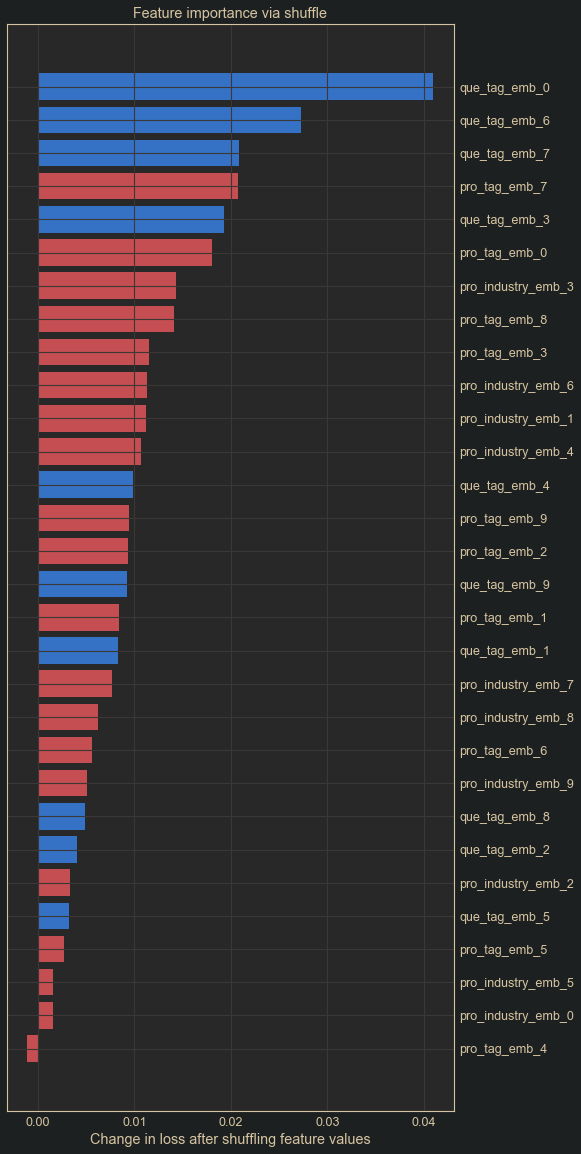

In [89]:
# calculate and plot test feature importance
fi = evaluation.permutation_importance(
    content_model, test_big_bg[0][0], test_big_bg[0][1],
    qfn, pfn, que_content_mask, pro_content_mask)
evaluation.plot_fi(fi, qfn, pfn)

### Date model feature importance

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - ETA:  - 0s 146us/step


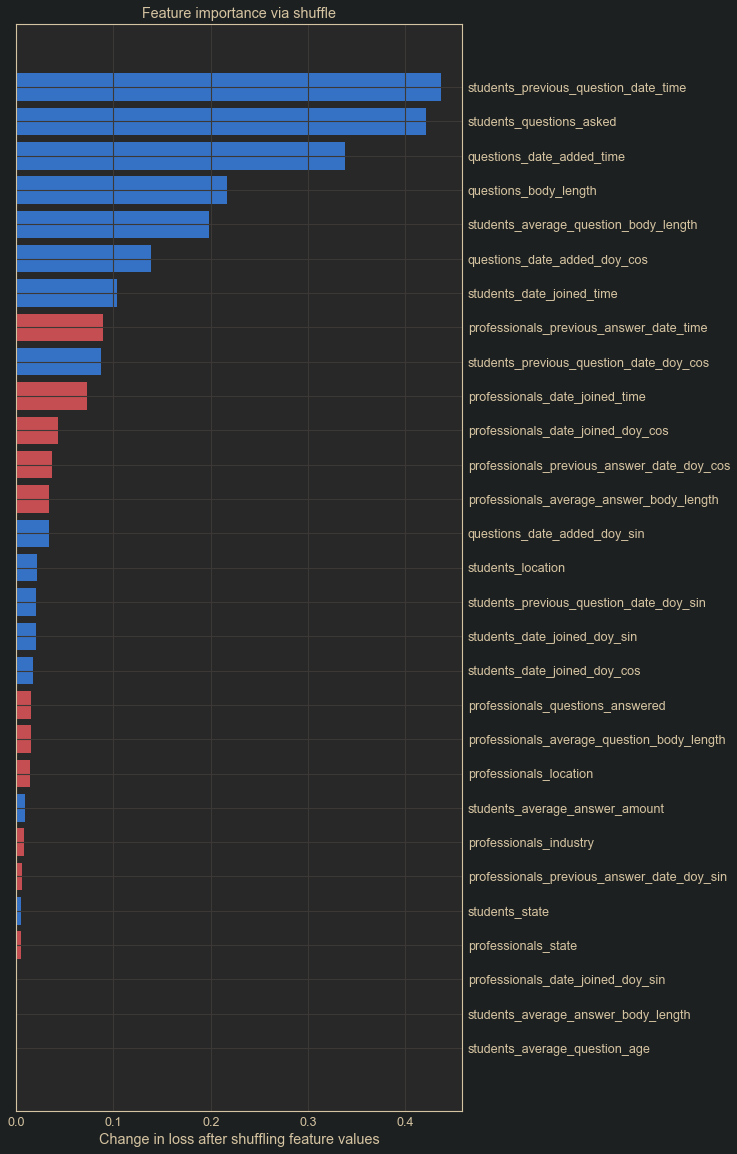

In [99]:
# calculate and plot train feature importance
fi = evaluation.permutation_importance(
    date_model, train_big_bg[0][0], train_big_bg[0][1],
    qfn, pfn, ~que_content_mask, ~pro_content_mask)
evaluation.plot_fi(fi, qfn, pfn)

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - ETA:  - 0s 133us/step


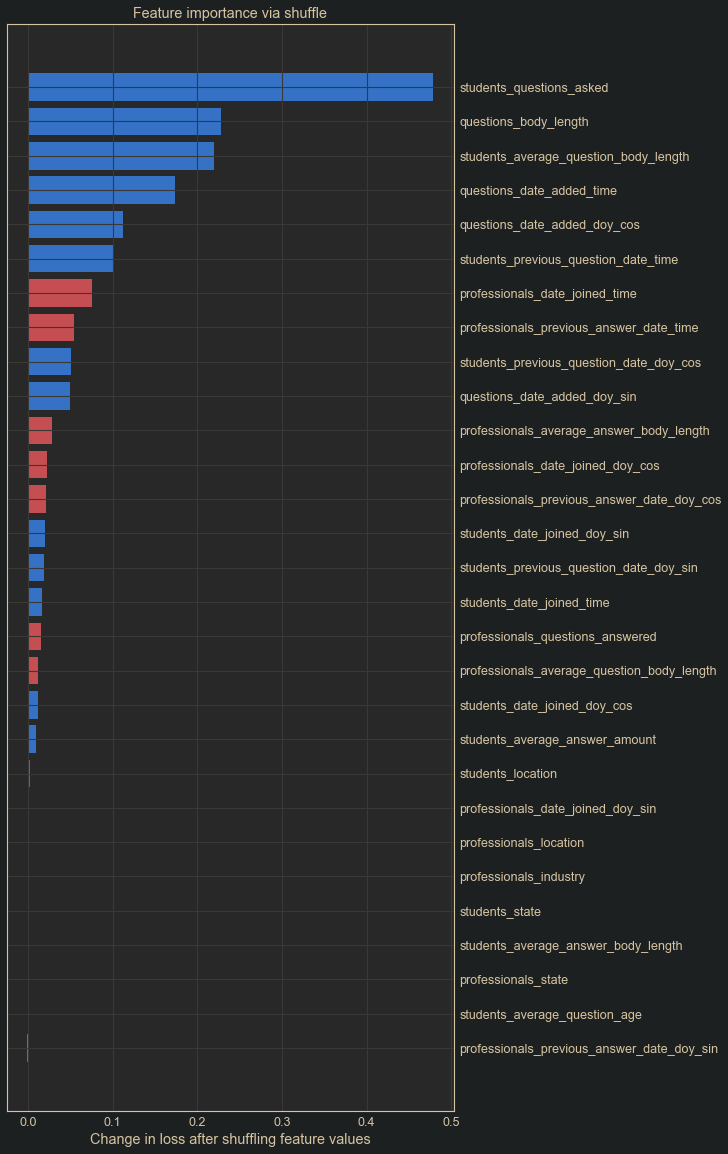

In [100]:
# calculate and plot test feature importance
fi = evaluation.permutation_importance(
    date_model, test_big_bg[0][0], test_big_bg[0][1],
    qfn, pfn, ~que_content_mask, ~pro_content_mask)
evaluation.plot_fi(fi, qfn, pfn)